In [73]:
import datetime
import pytz
import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tinkoff.invest import Client
from tinkoff.invest.schemas import InstrumentExchangeType, AssetsRequest, InstrumentStatus, InstrumentType

# Загрузка данных

In [74]:
f = open('secrets/sandbox-invest-public-api.tinkoff.ru.txt', 'r')
t_invest_token = f.read()
f.close()

To create a jupyter_notebook_config.py file, with all the defaults commented out, you can use the following command line:

$ jupyter notebook --generate-config

Open the file and search for c.NotebookApp.iopub_data_rate_limit

Comment out the line c.NotebookApp.iopub_data_rate_limit = 1000000 and change it to a higher default rate. l used c.NotebookApp.iopub_data_rate_limit = 10000000

In [75]:
companies = {}

with Client(t_invest_token) as client:
    
    r = client.instruments.shares()
    for share in r.instruments:
        if share.class_code == "TQBR"and share.currency == "rub":
            companies[share.ticker] = { 
                "share": share, 
                "dividends": [],
                "filtered_dividends": []
            }

    for ticker in companies.keys():
        r = client.instruments.get_dividends(figi=companies[ticker]["share"].figi, from_=datetime.datetime(2000, 1, 1))
        for dividend in r.dividends:
            companies[ticker]["dividends"] += [dividend]
            value = (dividend.yield_value.units + dividend.yield_value.nano*1.0e-9)
            if (     len(companies[ticker]["filtered_dividends"]) > 0
                # укрупняем выплаты до квартала 
                and  companies[ticker]["filtered_dividends"][len(companies[ticker]["filtered_dividends"]) -1]["date"] 
                        < dividend.last_buy_date + datetime.timedelta(days=89)
               ):
                companies[ticker]["filtered_dividends"][len(companies[ticker]["filtered_dividends"]) -1]["value"] += value
            else:
                companies[ticker]["filtered_dividends"] += [{"date": dividend.last_buy_date, "value": value}]



print("Загружено ", len(companies.keys()), " компаний")
print(", ".join(str(element) for element in companies.keys()))
    

Загружено  154  компаний
VSMO, UNAC, CNRU, VKCO, MGNT, ETLN, KZOSP, WUSH, UGLD, LNZL, SELG, PRFN, CARM, RUAL, NKHP, ALRS, DIAS, TATN, RTKM, PRMD, TGKN, TRNFP, RAGR, GCHE, UWGN, SNGSP, NKNC, VRSB, MBNK, MOEX, OZON, KAZTP, SNGS, TGKBP, PIKK, ROSN, EUTR, MRKU, ENPG, T, MRKV, CNTL, VSEH, SVAV, KMAZ, KZOS, ELFV, HEAD, SMLT, SBER, GECO, GAZP, BSPB, LSNG, RENI, POSI, KROT, SIBN, KLSB, CHMK, MRKZ, APTK, HYDR, LNZLP, SFIN, RASP, GMKN, UPRO, MSNG, AFKS, PLZL, LEAS, CNTLP, LIFE, DATA, IRKT, TTLK, SVCB, GEMC, PHOR, HNFG, HHRU, TATNP, MAGN, VTBR, BANEP, OKEY, MRKP, FLOT, ABIO, DVEC, ZAYM, MTSS, OZPH, FEES, PMSB, RBCM, MSRS, IRAO, NSVZ, BLNG, X5, NVTK, UNKL, AQUA, ROLO, OGKB, CBOM, ABRD, TRMK, SOFL, KRKNP, CHMF, NKNCP, LSRG, RTKMP, FIXP, MGTSP, KLVZ, VEON-RX, YDEX, BANE, AFLT, MVID, PMSBP, MSTT, MTLR, IVAT, AKRN, MDMG, SBERP, LENT, ASTR, RKKE, MRKC, KAZT, YAKG, TGKB, RNFT, QIWI, GTRK, NLMK, BELU, FESH, SGZH, LSNGP, MRKS, LKOH, DELI, MGKL, NMTP, TGKA, MTLRP, MRKY


# Обработка данных

In [76]:
#отсекаем компании не платившие дивиденты больше года или  менее однго раза в год
filtred_companies = {}
excluded = []
for ticker in companies.keys():
    if(  
            len(companies[ticker]["filtered_dividends"]) >= 2
        and companies[ticker]["filtered_dividends"][0]["date"] + datetime.timedelta(days=365) >= datetime.datetime.now(pytz.utc) 
        and len([d for d in companies[ticker]["dividends"] if d.dividend_net.currency != "rub"]) == 0
      ): 
        filtred_companies[ticker] = companies[ticker]
    else:
        excluded += [ticker]

print("Исключенные из анализа компании:")
print(", ".join(str(ticker) for ticker in excluded))
print("")
print("Оставшиеся компании: " + str(len(filtred_companies.keys()))  )
print(", ".join(str(ticker) for ticker in filtred_companies.keys()))

Исключенные из анализа компании:
UNAC, CNRU, VKCO, ETLN, UGLD, PRFN, CARM, RUAL, PRMD, RAGR, UWGN, MBNK, OZON, TGKBP, PIKK, ENPG, T, VSEH, ELFV, HEAD, SMLT, GECO, GAZP, KLSB, CHMK, MRKZ, APTK, HYDR, RASP, GMKN, UPRO, LIFE, DATA, IRKT, GEMC, HHRU, OKEY, DVEC, FEES, RBCM, NSVZ, BLNG, X5, UNKL, ROLO, OGKB, CBOM, SOFL, FIXP, MGTSP, KLVZ, VEON-RX, AFLT, MVID, MSTT, MTLR, IVAT, LENT, RKKE, YAKG, TGKB, RNFT, QIWI, GTRK, FESH, SGZH, MRKS, DELI, MGKL, TGKA, MTLRP, MRKY

Оставшиеся компании: 82
VSMO, MGNT, KZOSP, WUSH, LNZL, SELG, NKHP, ALRS, DIAS, TATN, RTKM, TGKN, TRNFP, GCHE, SNGSP, NKNC, VRSB, MOEX, KAZTP, SNGS, ROSN, EUTR, MRKU, MRKV, CNTL, SVAV, KMAZ, KZOS, SBER, BSPB, LSNG, RENI, POSI, KROT, SIBN, LNZLP, SFIN, MSNG, AFKS, PLZL, LEAS, CNTLP, TTLK, SVCB, PHOR, HNFG, TATNP, MAGN, VTBR, BANEP, MRKP, FLOT, ABIO, ZAYM, MTSS, OZPH, PMSB, MSRS, IRAO, NVTK, AQUA, ABRD, TRMK, KRKNP, CHMF, NKNCP, LSRG, RTKMP, YDEX, BANE, PMSBP, AKRN, MDMG, SBERP, ASTR, MRKC, KAZT, NLMK, BELU, LSNGP, LKOH, NMTP


# Визуализация

## Лучшие компании

In [81]:
# строим серии графиков

def calck_graphs( input_companies, years_limit ):
    result = []
    for ticker in input_companies.keys():

        data = [ {"date": d["date"], "value": d["value"], "year_value":0 } for d in input_companies[ticker]["filtered_dividends"] ] 
        graph = {
            "average": 0, 
            "x":[], 
            "y":[], 
            "ticker": input_companies[ticker]["share"].ticker,
            "name": input_companies[ticker]["share"].name,
            "sector": input_companies[ticker]["share"].sector,
            "data": data
        }
        
        sum_value = 0
        sum_days = 0
        for div_id in range(len(data)-2, -1, -1):
            date = data[div_id]["date"]
            
            #отбираем данные за последние years_limit года
            if date + datetime.timedelta(days=365*years_limit) < datetime.datetime.now(pytz.utc):
                continue
            
            #определяем количество дней с последней выплаты дивидендов
            days = (date - data[div_id+1]["date"]).days
            
            #определяем среднее годовое значение дивидендов за дни после предыдущей выплаты
            data[div_id]["year_value"] = data[div_id]["value"] / ( days / 365 ) 
            
            graph["x"] += [date]
            graph["y"] += [data[div_id]["year_value"]]
            
            sum_value += data[div_id]["year_value"] * days
            sum_days += days
    
        graph["average"] = sum_value / sum_days
        result += [graph]
    
    return sorted(result, key=lambda fc: fc["average"], reverse=True)

In [110]:
#указываем количество последних лет, за которые будет произведен анализ
graphs = calck_graphs(filtred_companies, 2.5)

In [111]:
legend_colors = {
    "materials": "lightblue",
    "consumer": "pink",
    "industrials": "grey",
    "it": "yellow",
    "energy": "black",
    "utilities": "orange",
    "telecom": "red",
    "financial": "green",
    "health_care": "lightgreen",
    "real_estate": "brown",
    "other": "blue"
}

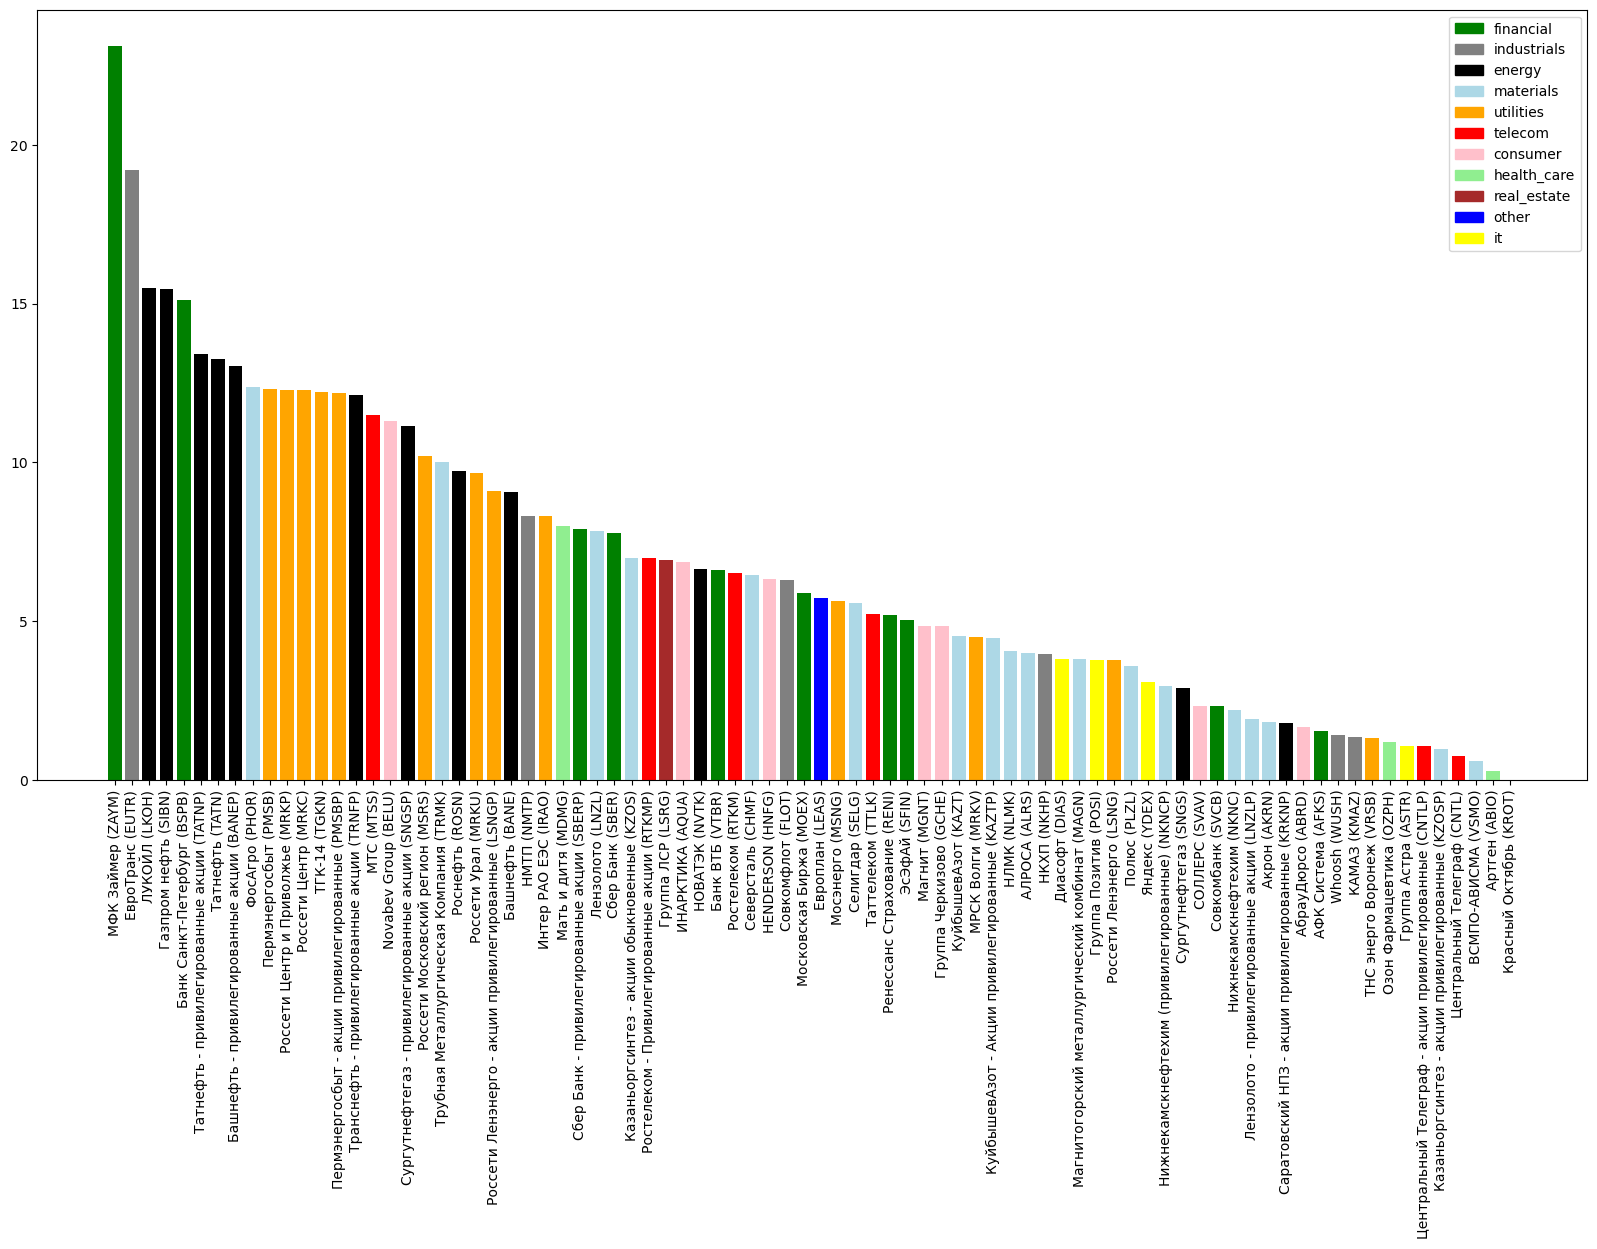

In [112]:
x = []
y = []
colors = []
patchs = {}
for g in graphs:
    
    x += [g["name"] + " (" + g["ticker"] + ")"]
    y += [g["average"]]
    
    sector = g["sector"]
    colors += [legend_colors[sector]]
    patchs[sector] = mpatches.Patch(color=legend_colors[sector], label=sector)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x, y, color=colors)
ax.tick_params(axis='x', labelrotation=90)
ax.legend(handles=patchs.values())

## Графики выплат

In [113]:
def draw_graphs(gr, start, end):
    plt.figure(figsize=(20,20))
    legend = []
    for i in range(start,end):
        if i >= len(gr):
            break
            
        fc = gr[i]
        legend += [fc["name"]]
        plt.plot(fc["x"], fc["y"])
    plt.legend(legend)

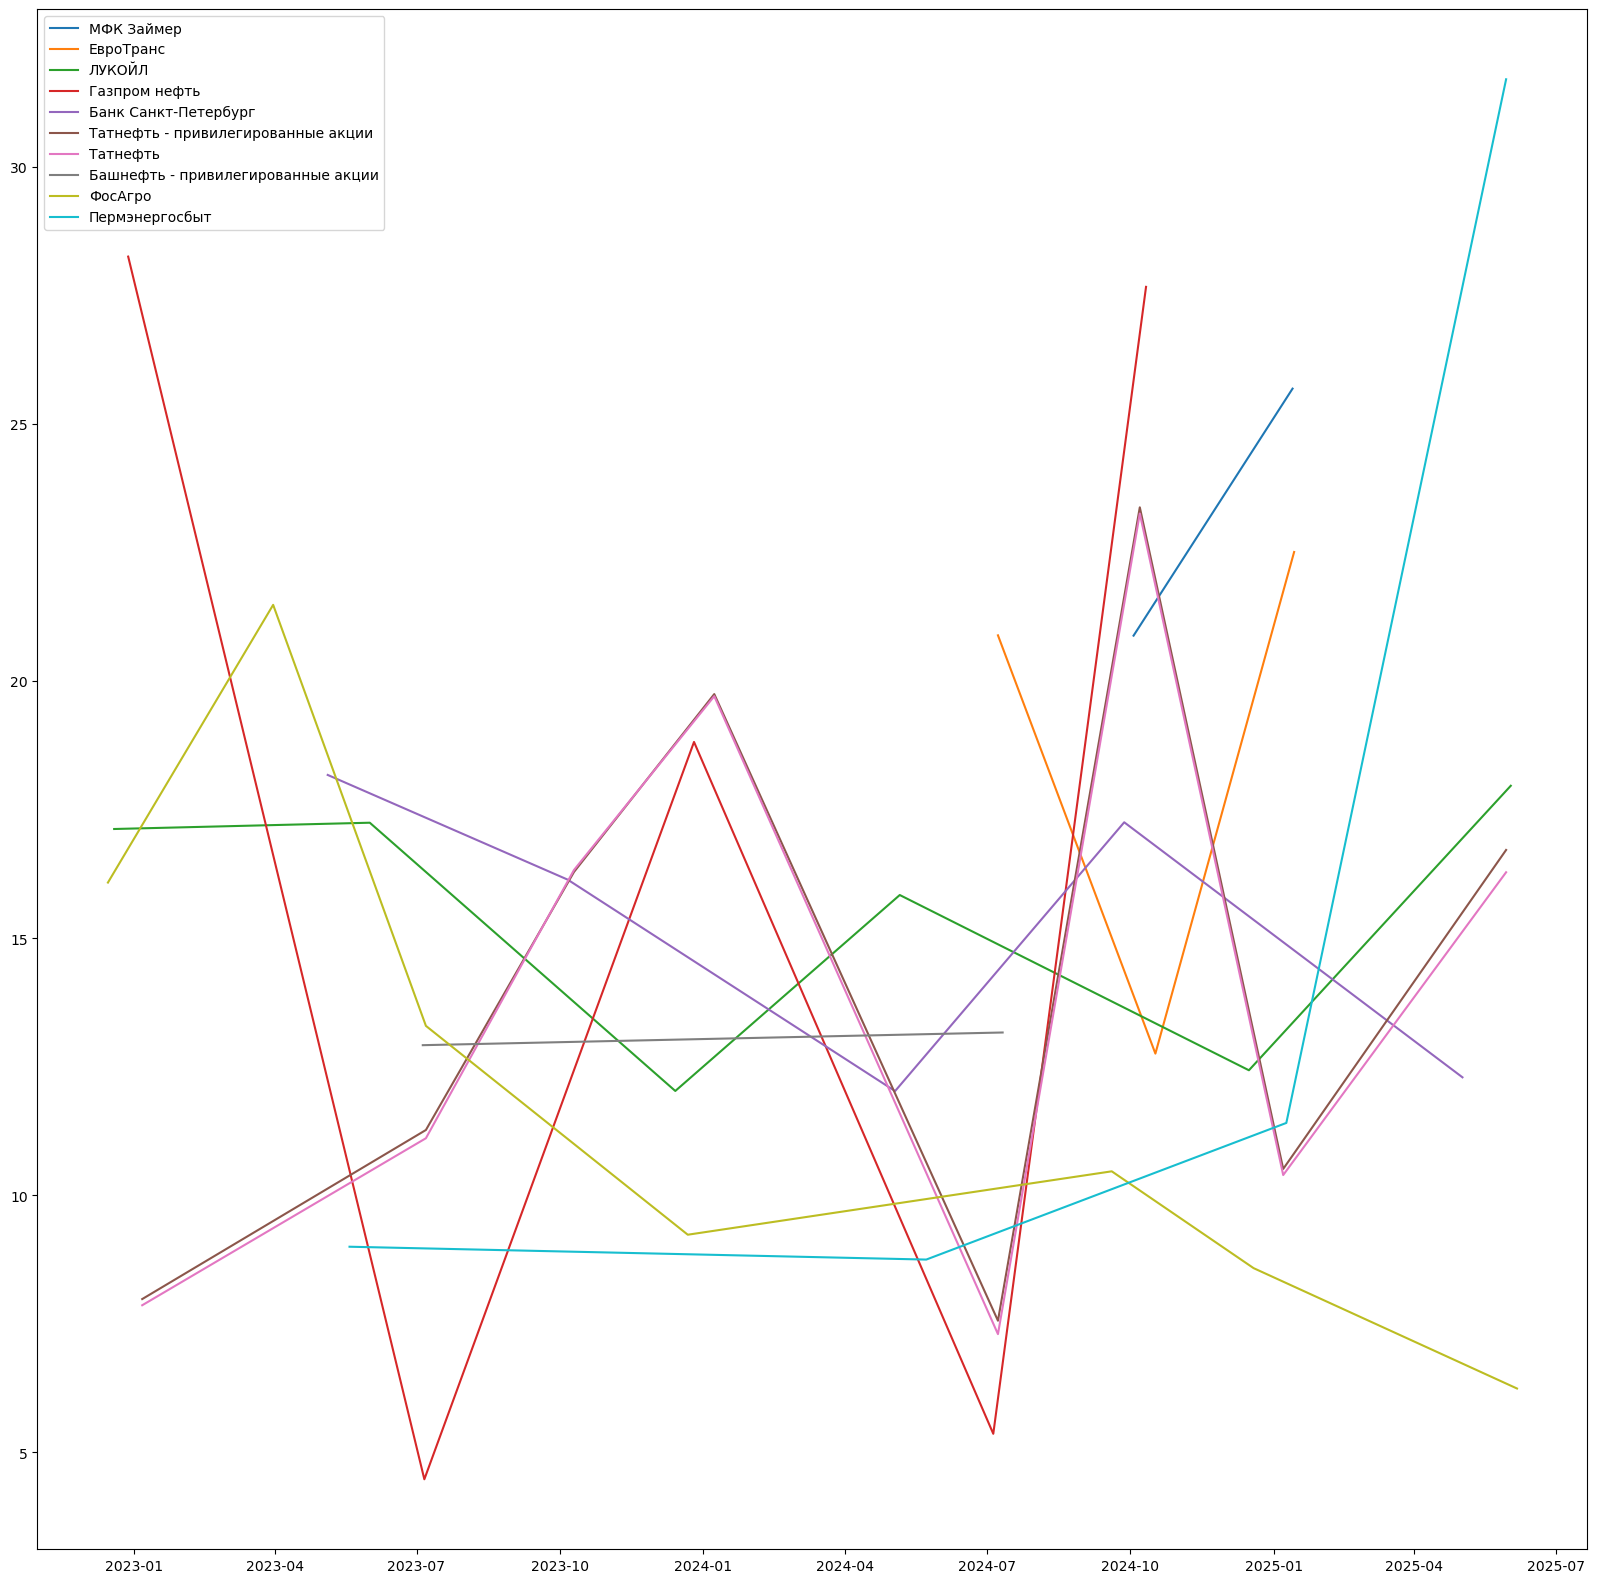

In [114]:
draw_graphs(graphs, 0, 10)

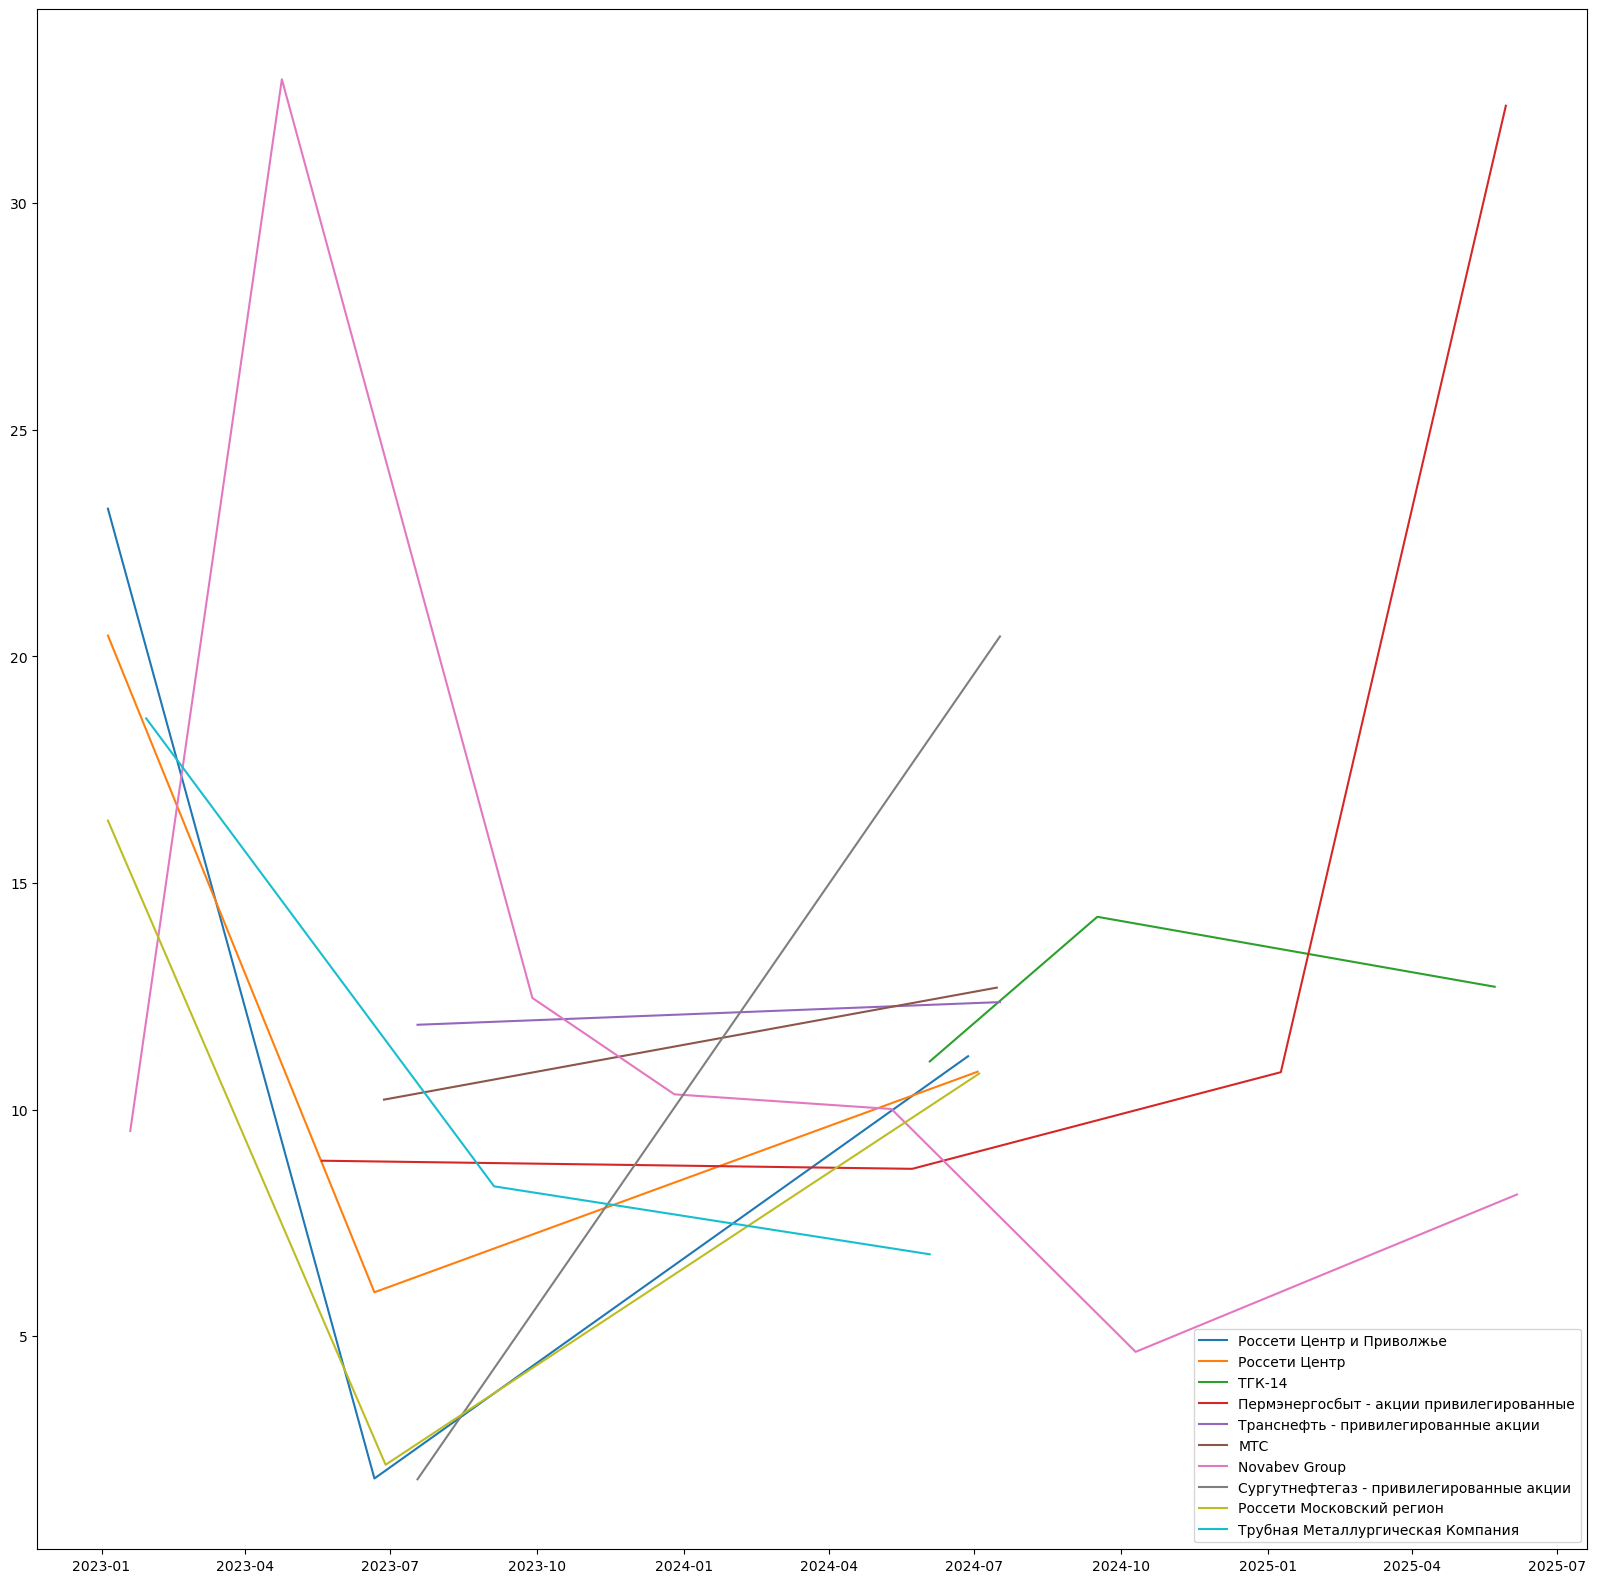

In [115]:
draw_graphs(graphs, 10, 20)

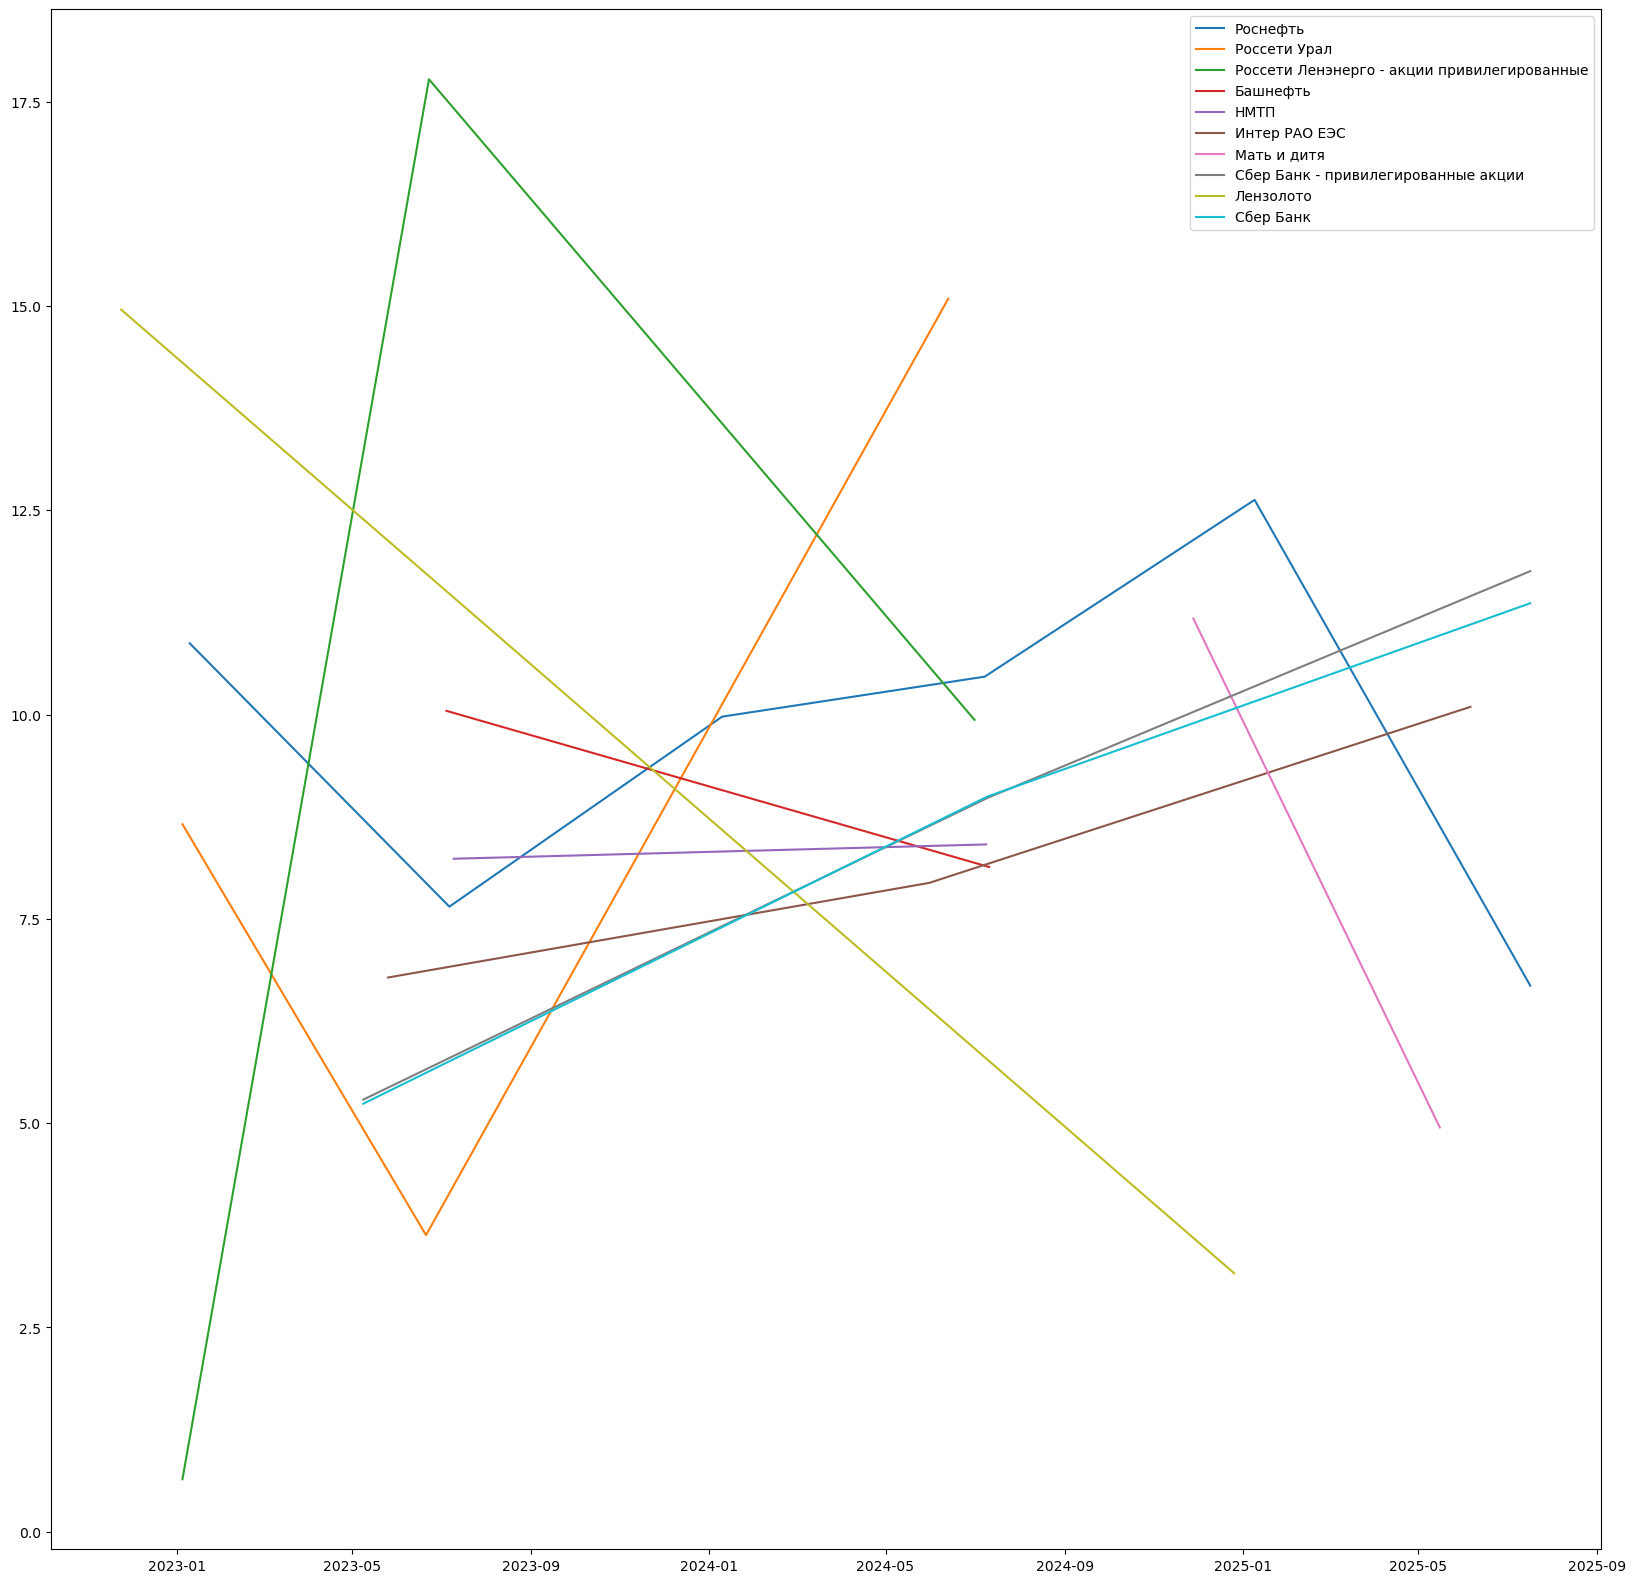

In [116]:
draw_graphs(graphs, 20, 30)

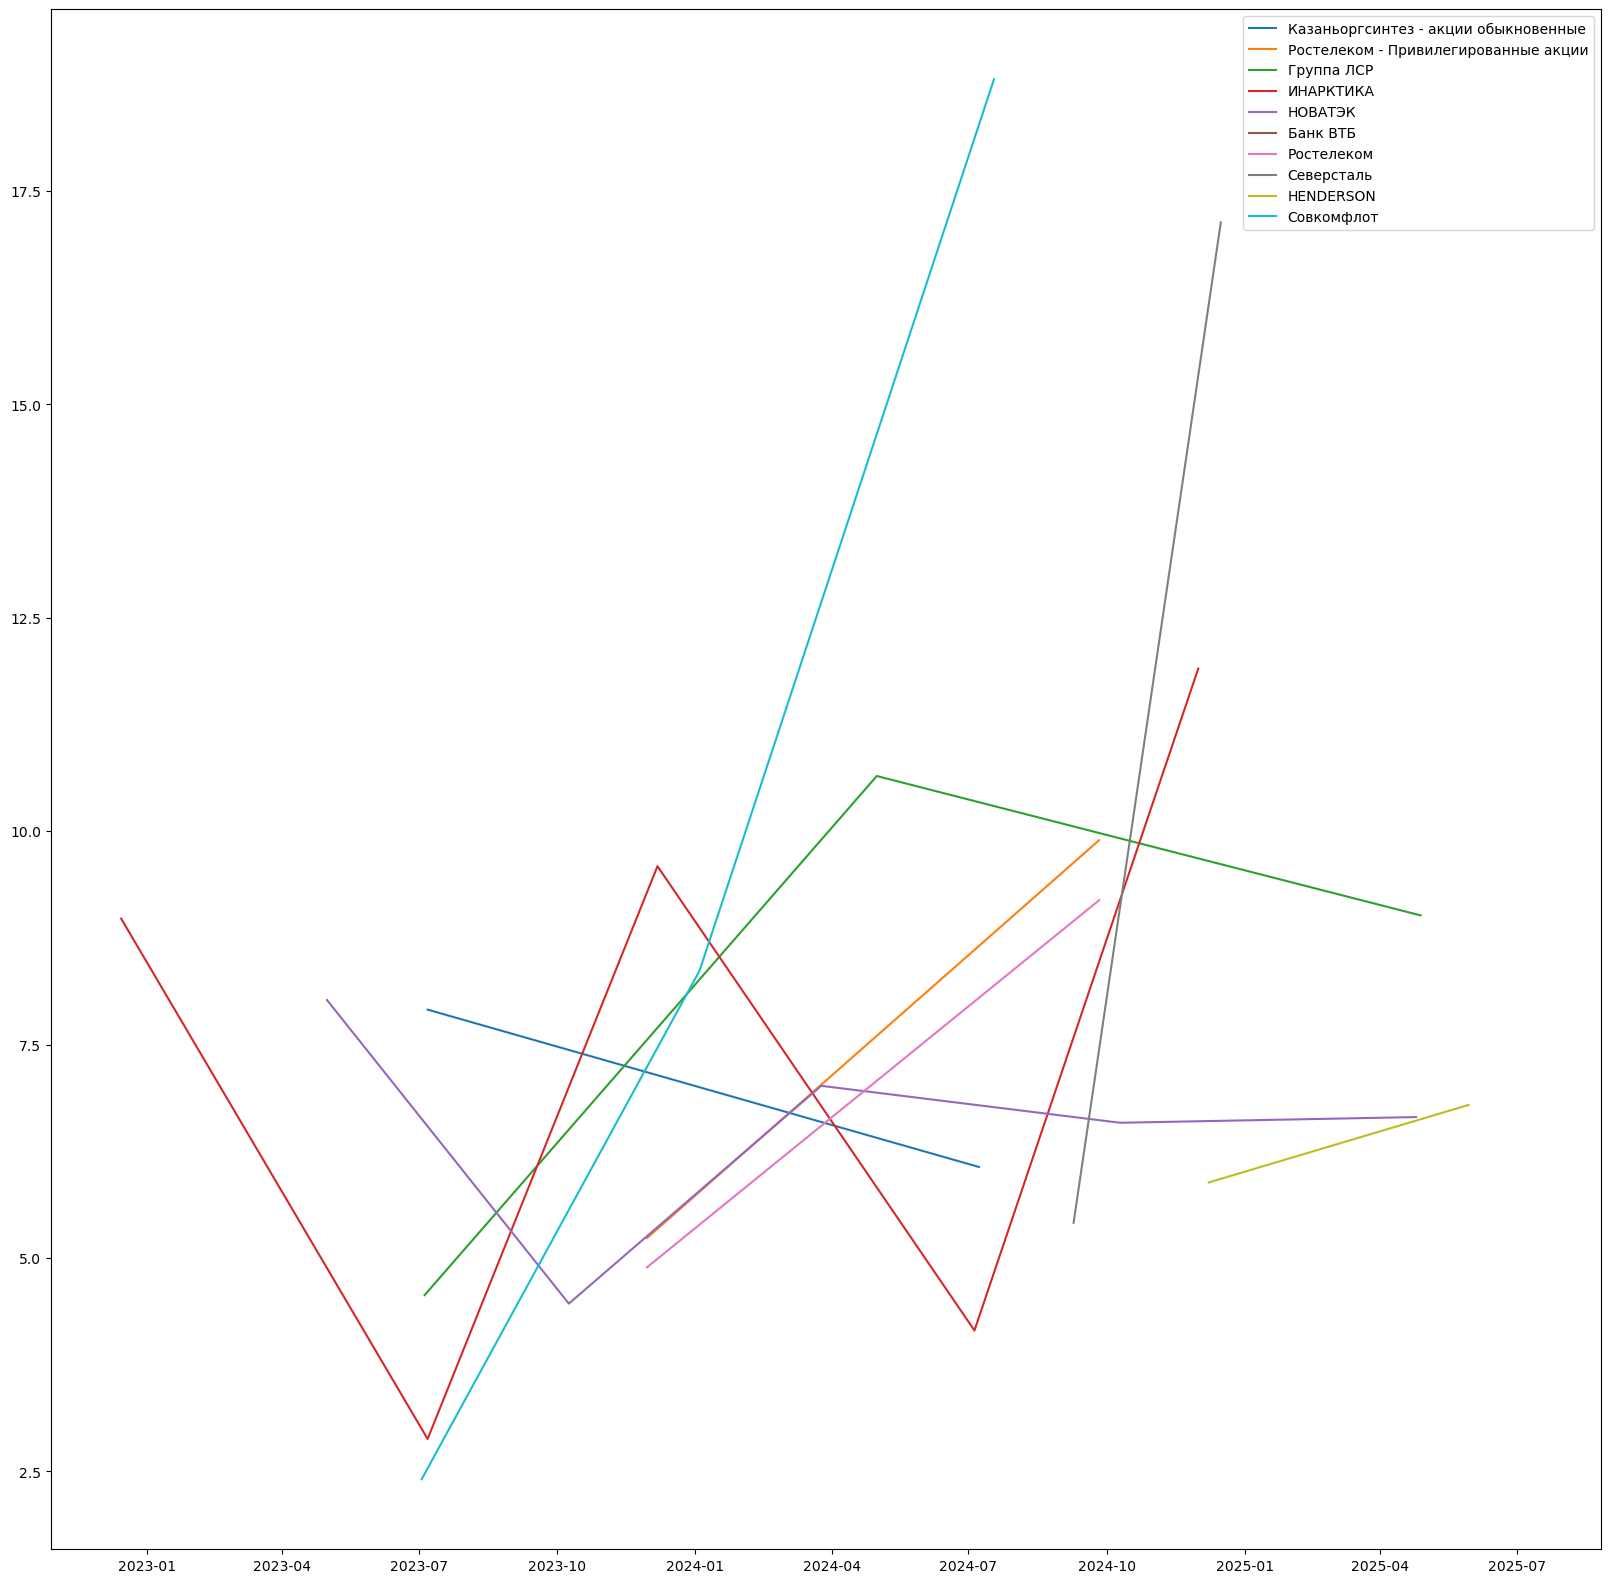

In [117]:
draw_graphs(graphs, 30, 40)

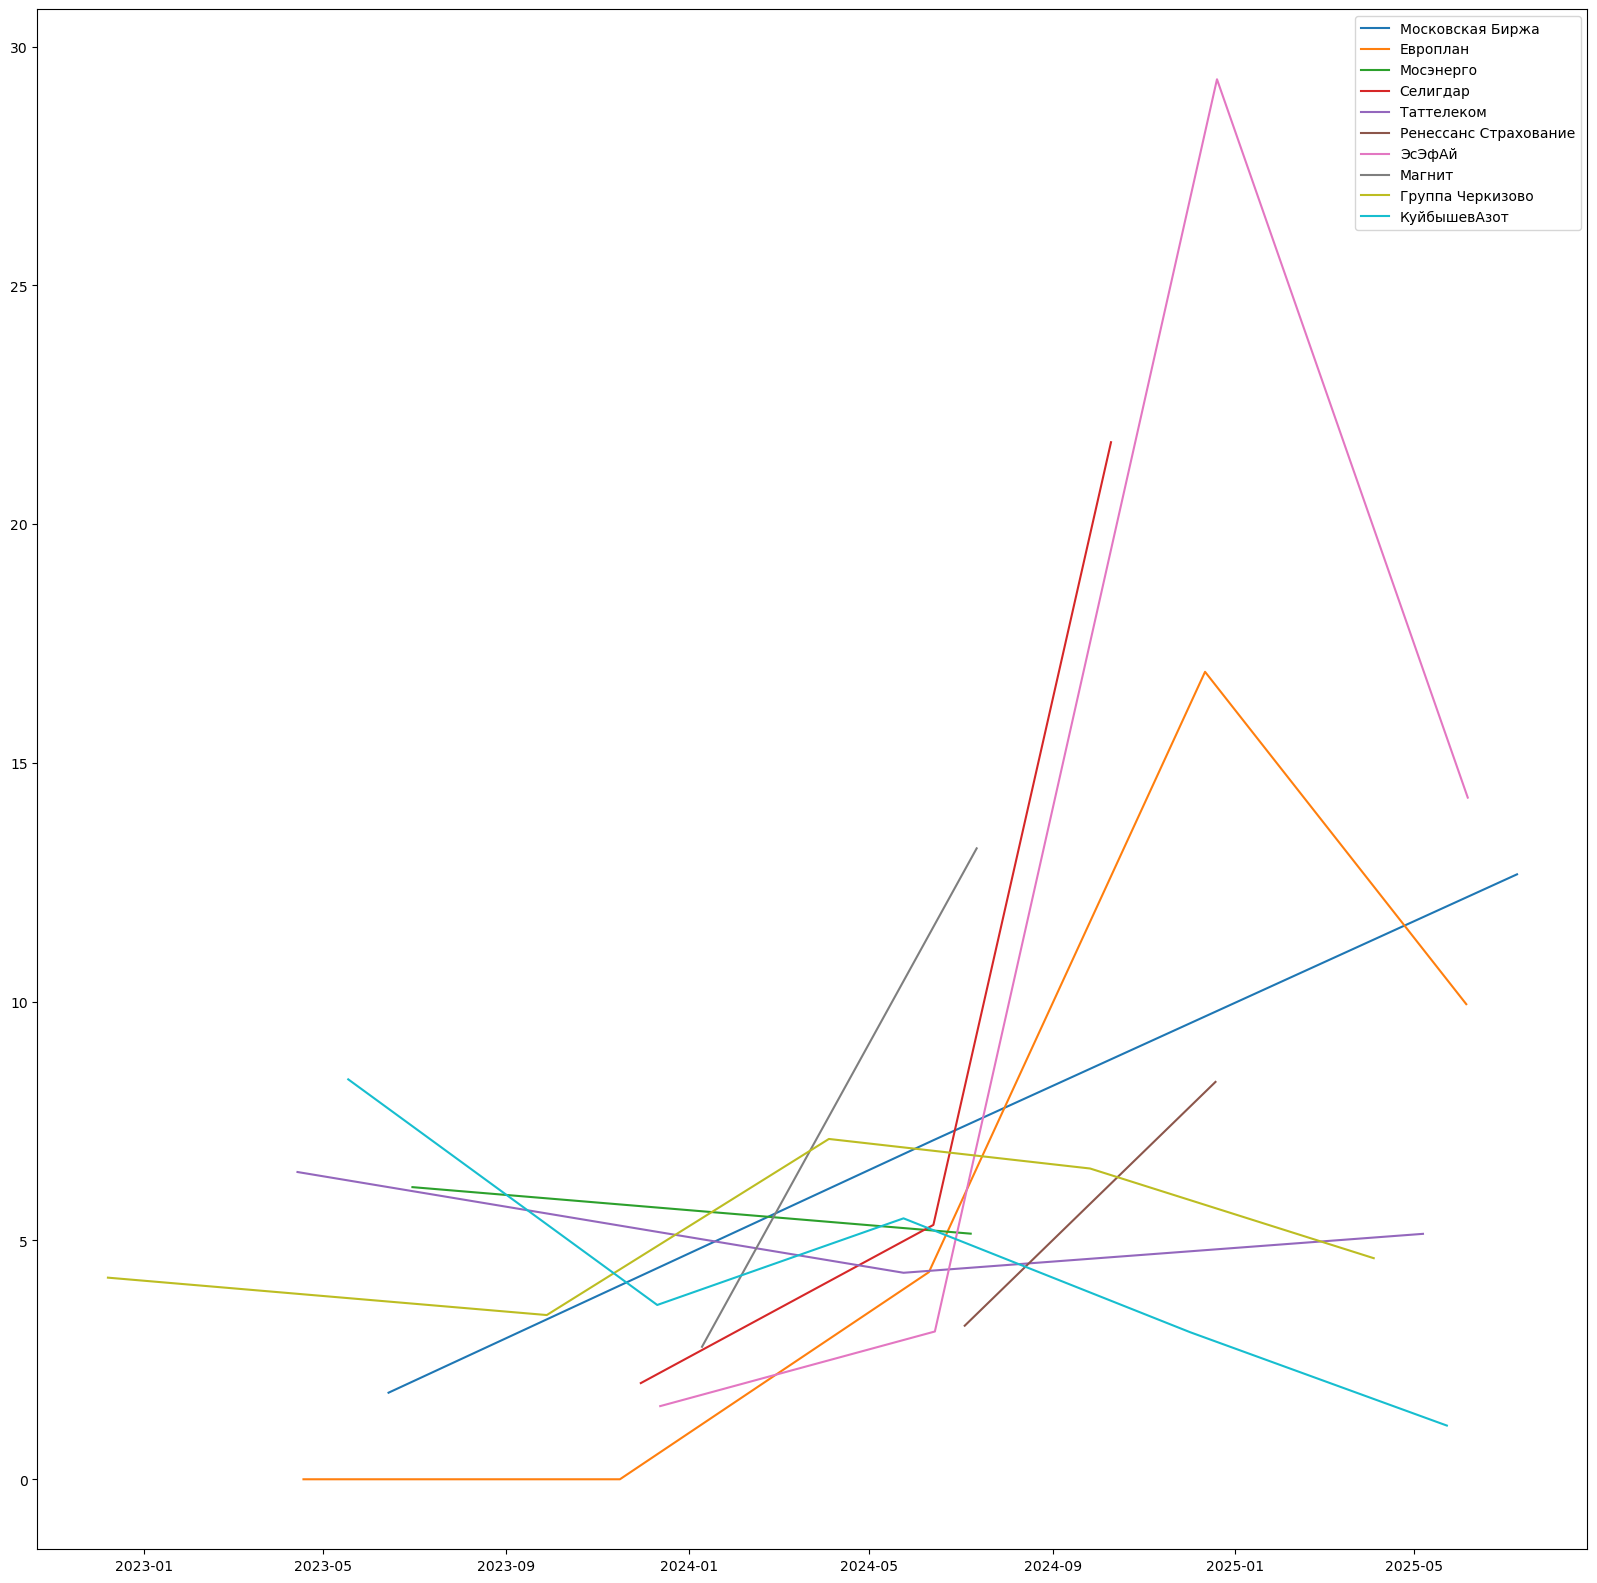

In [118]:
draw_graphs(graphs, 40, 50)

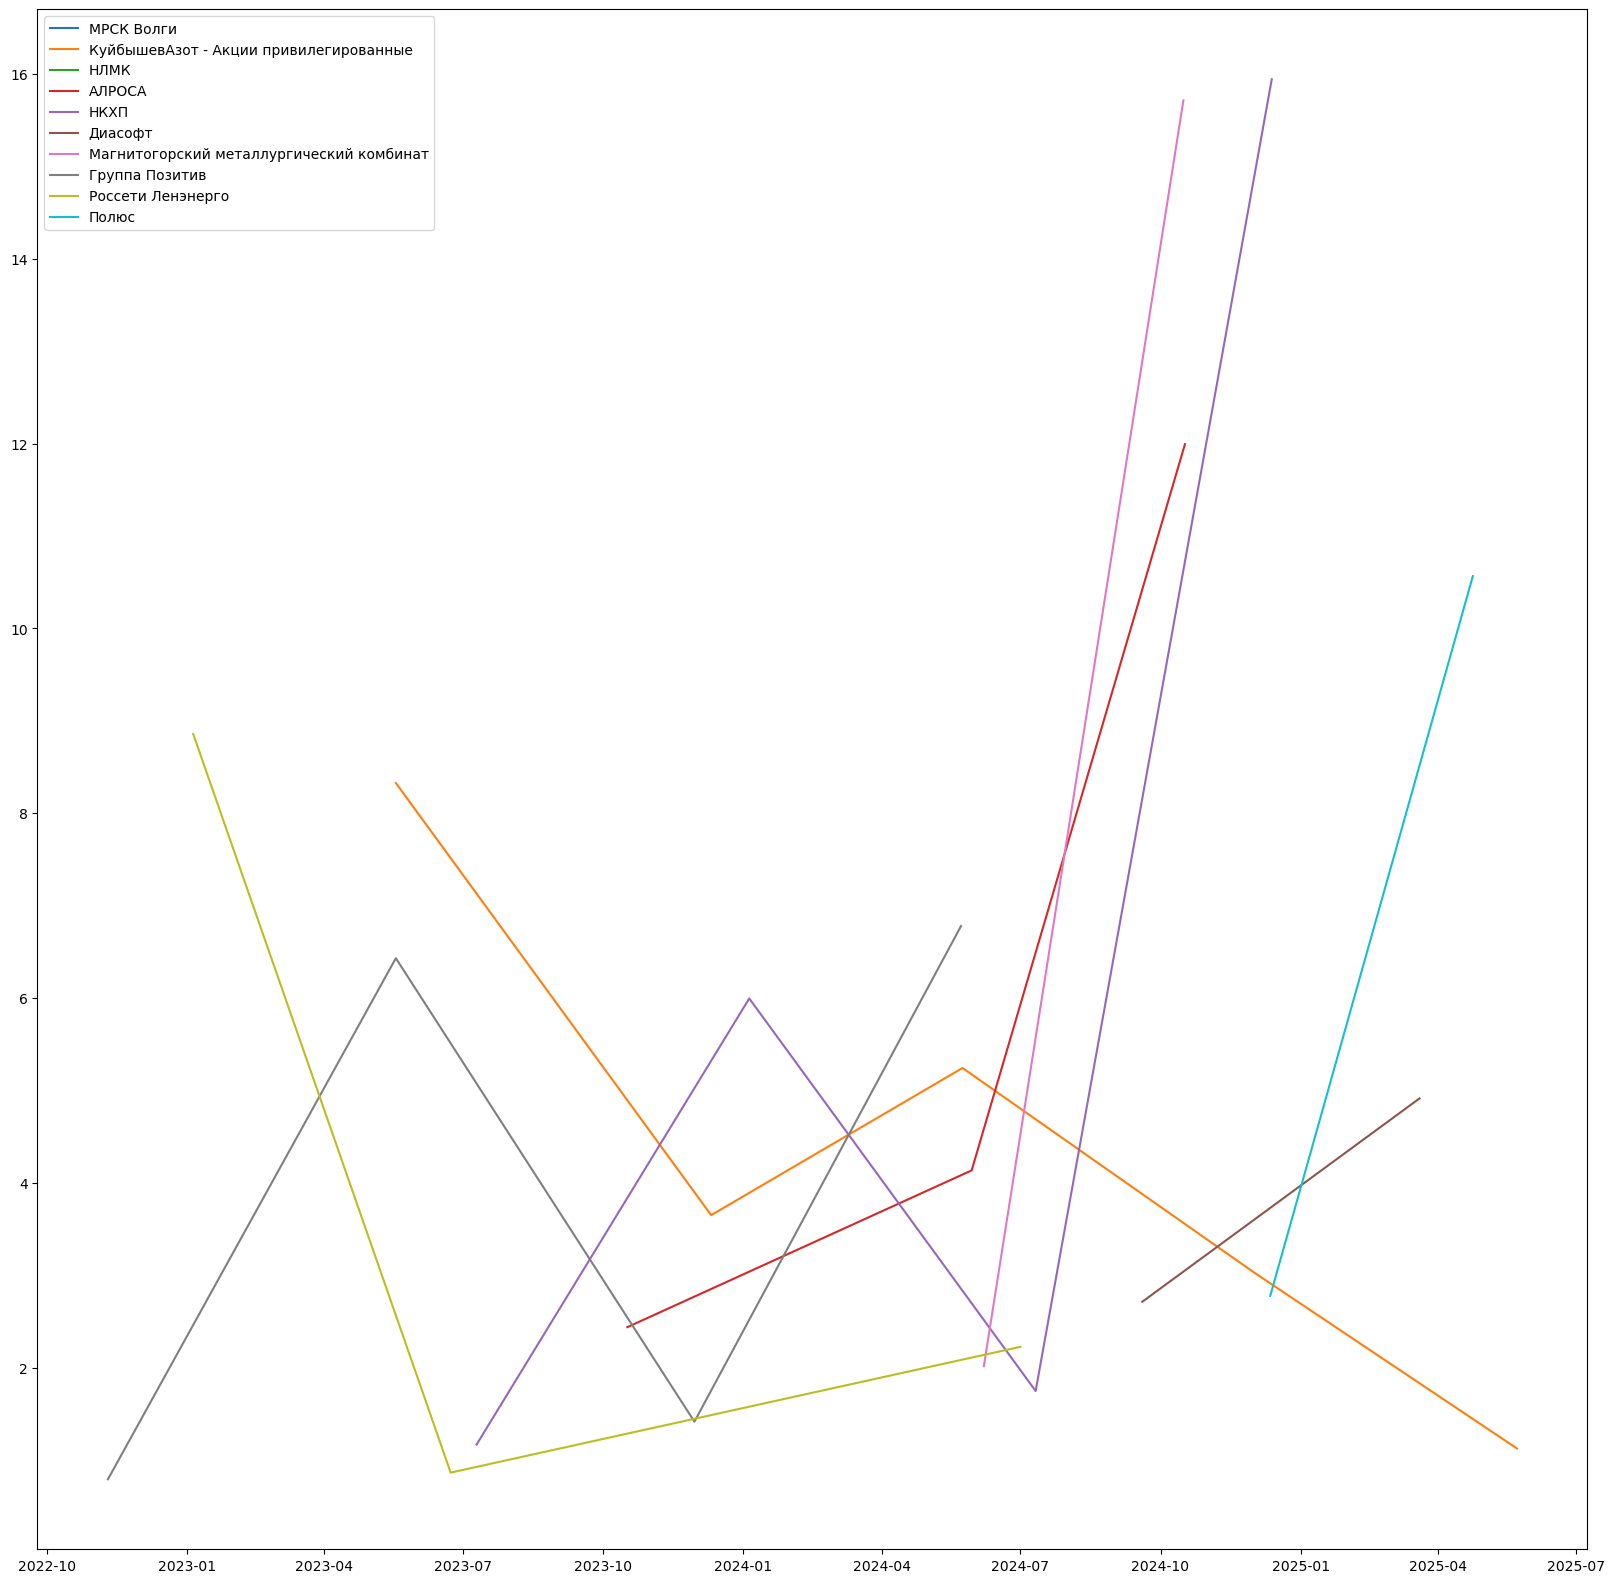

In [119]:
draw_graphs(graphs, 50, 60)

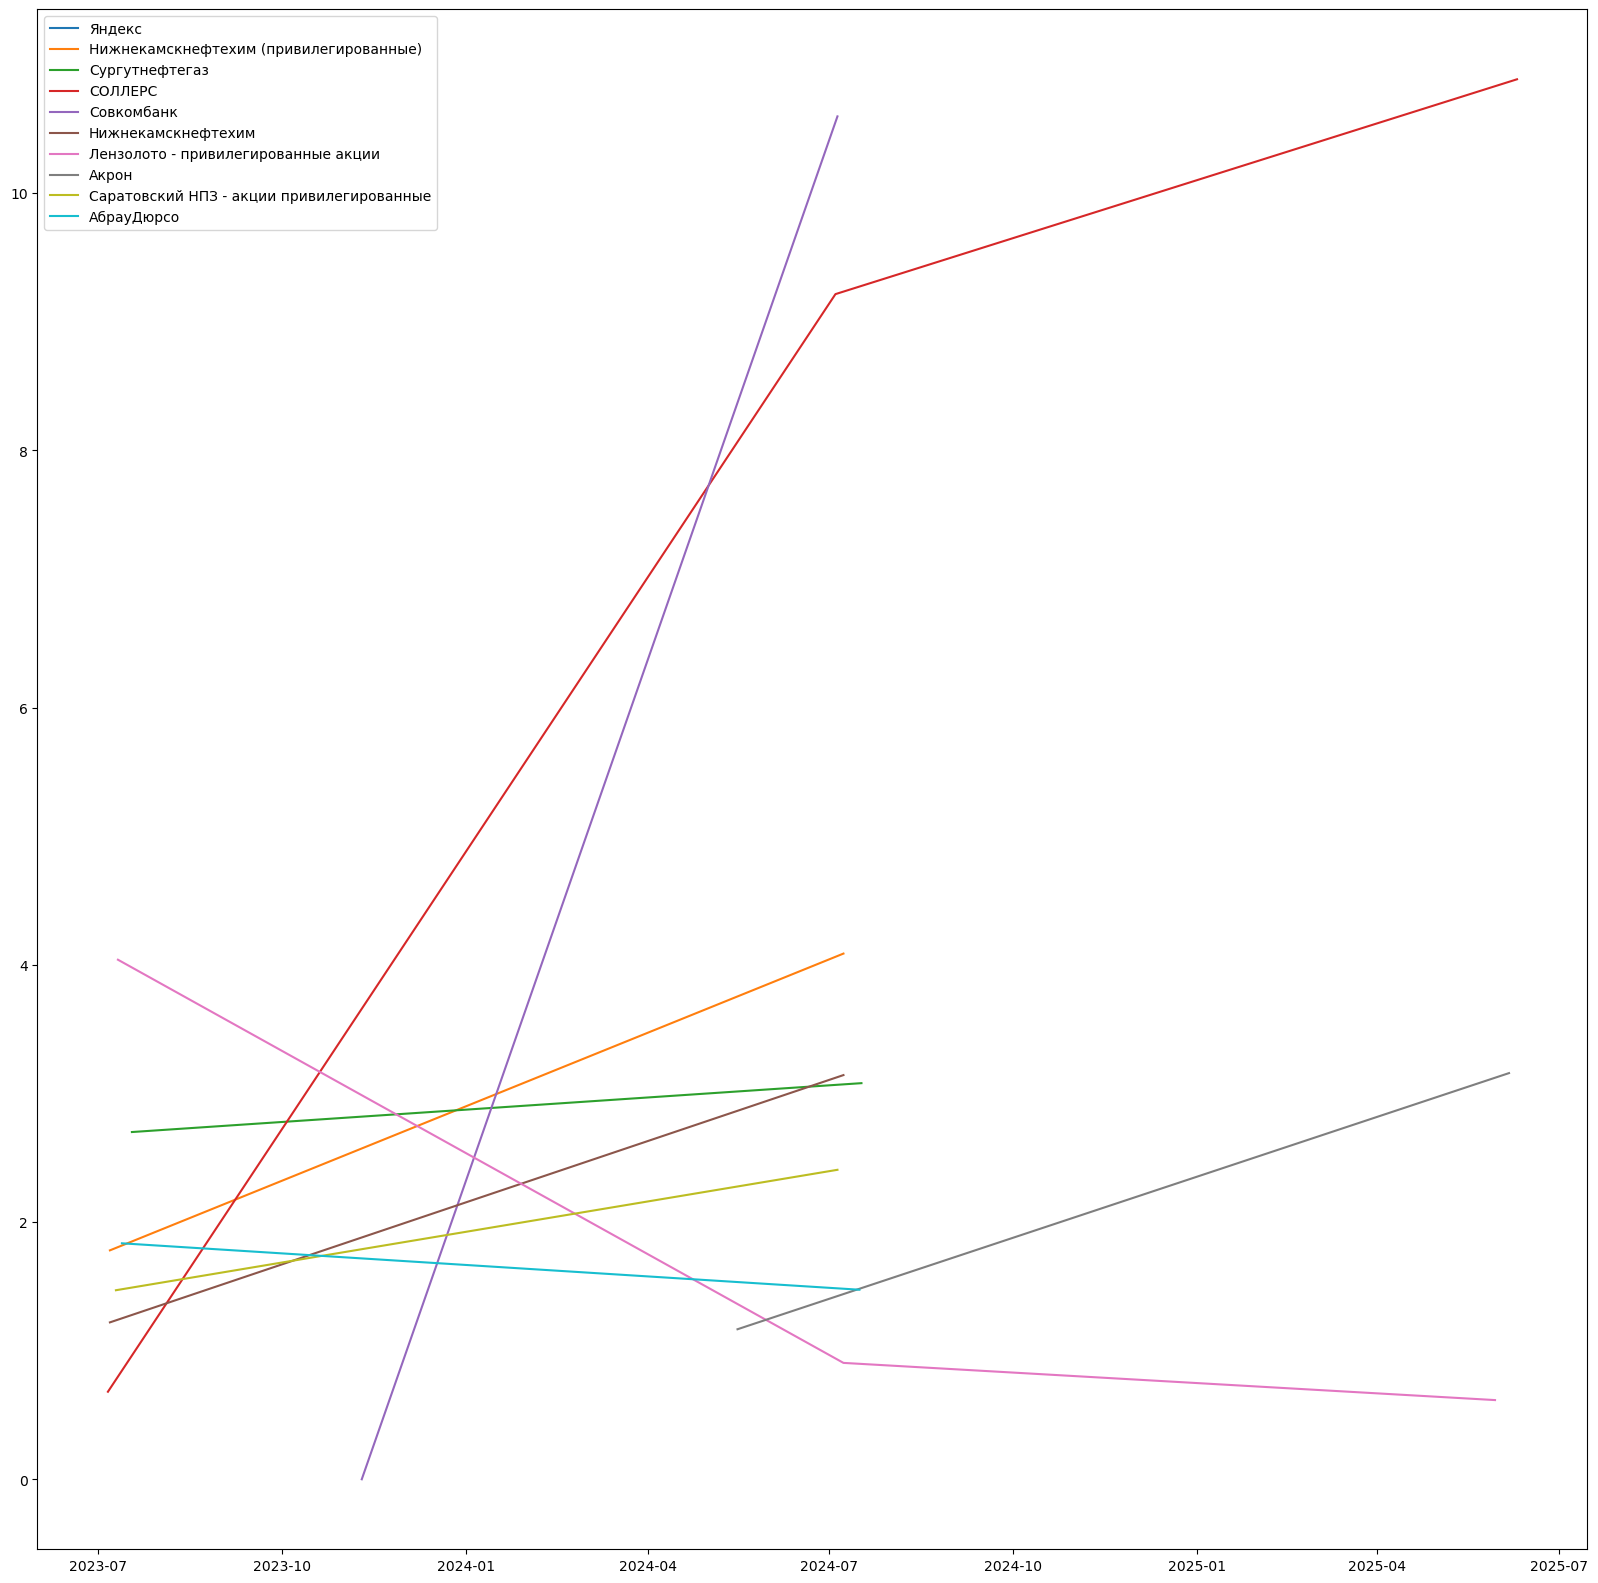

In [120]:
draw_graphs(graphs, 60, 70)

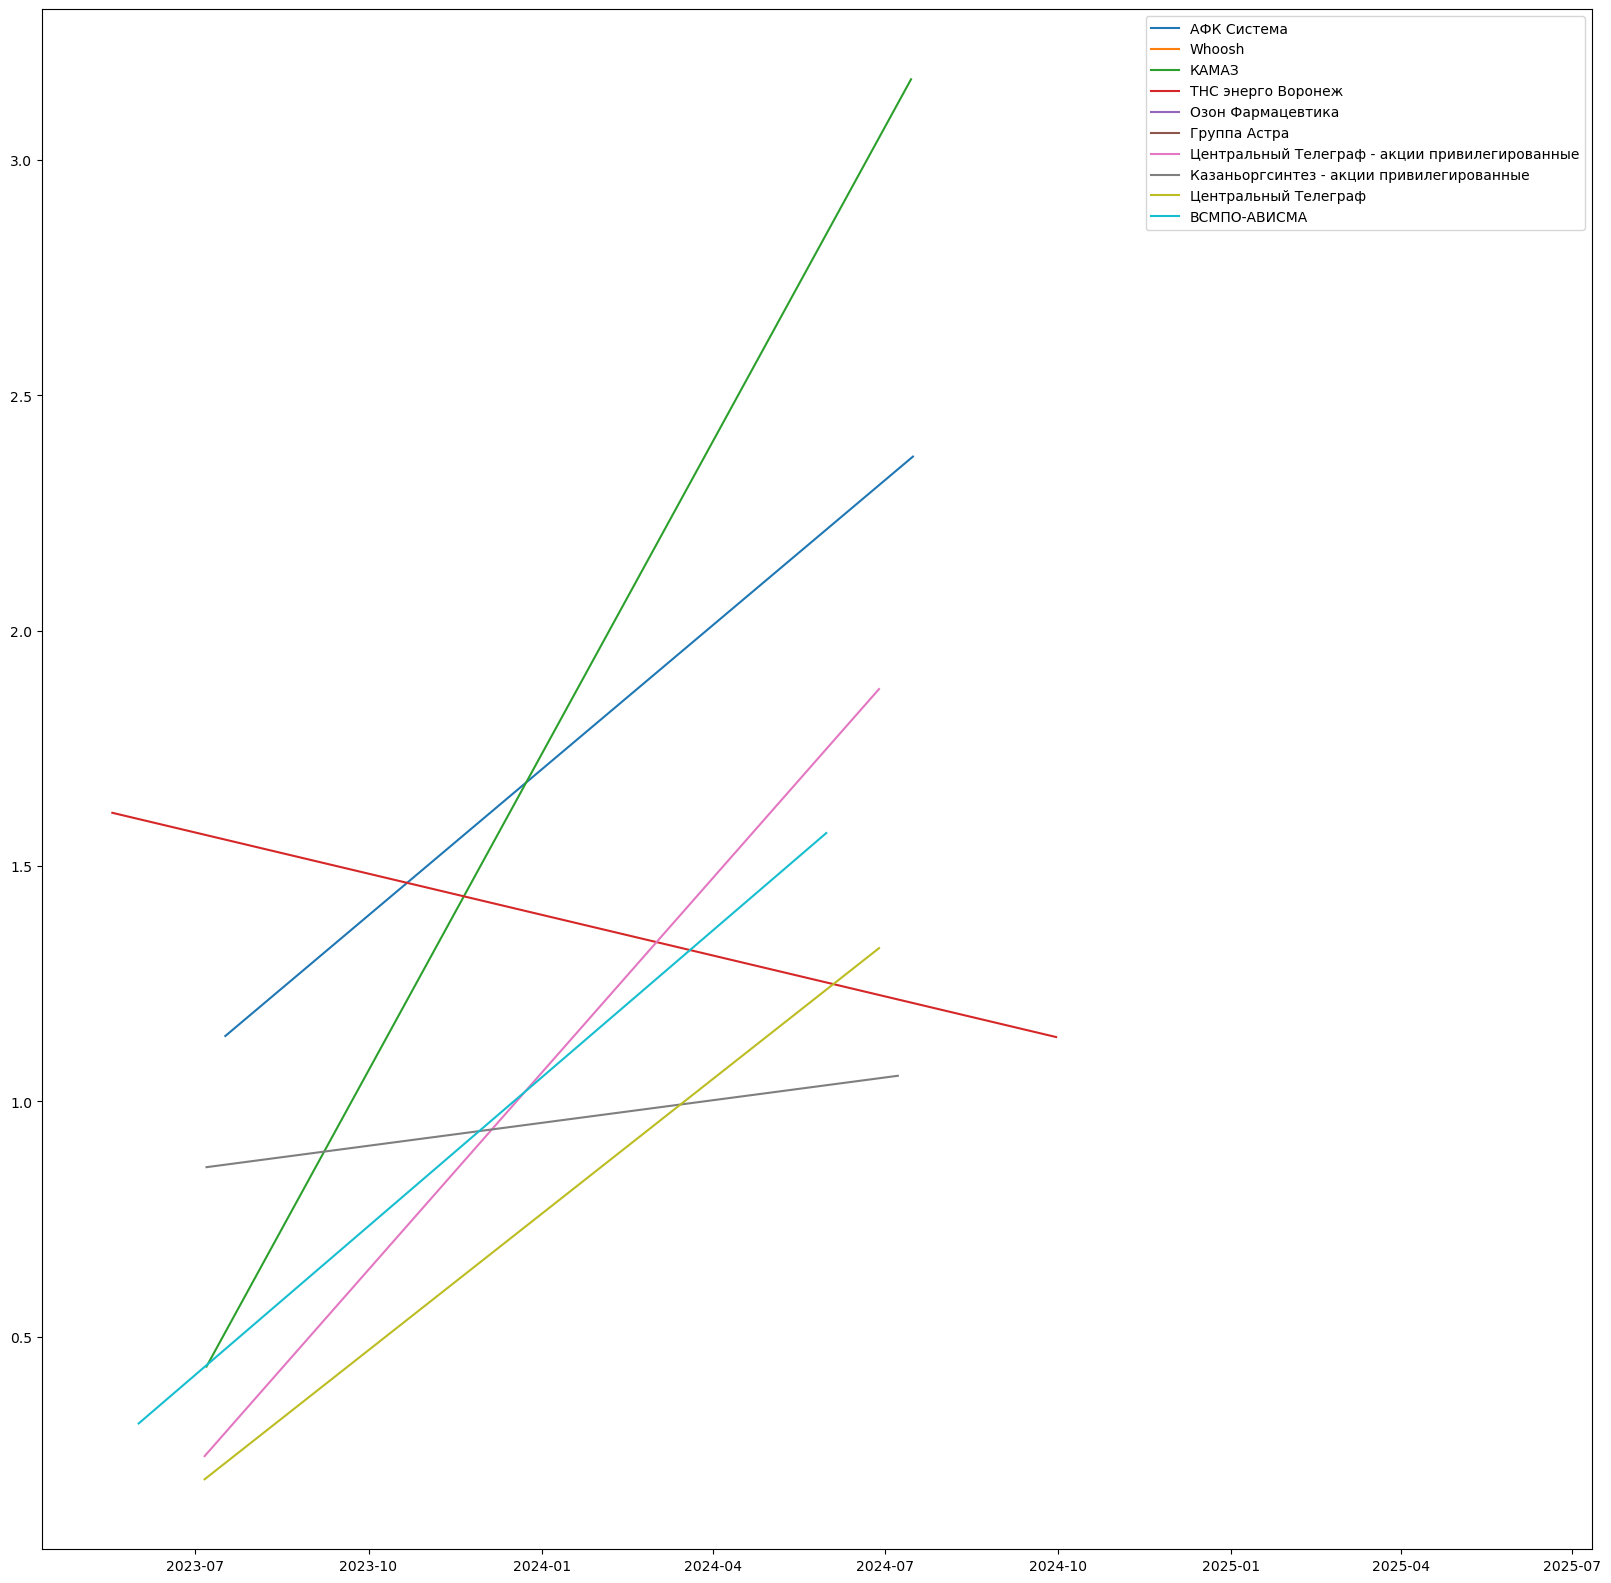

In [121]:
draw_graphs(graphs, 70, 80)

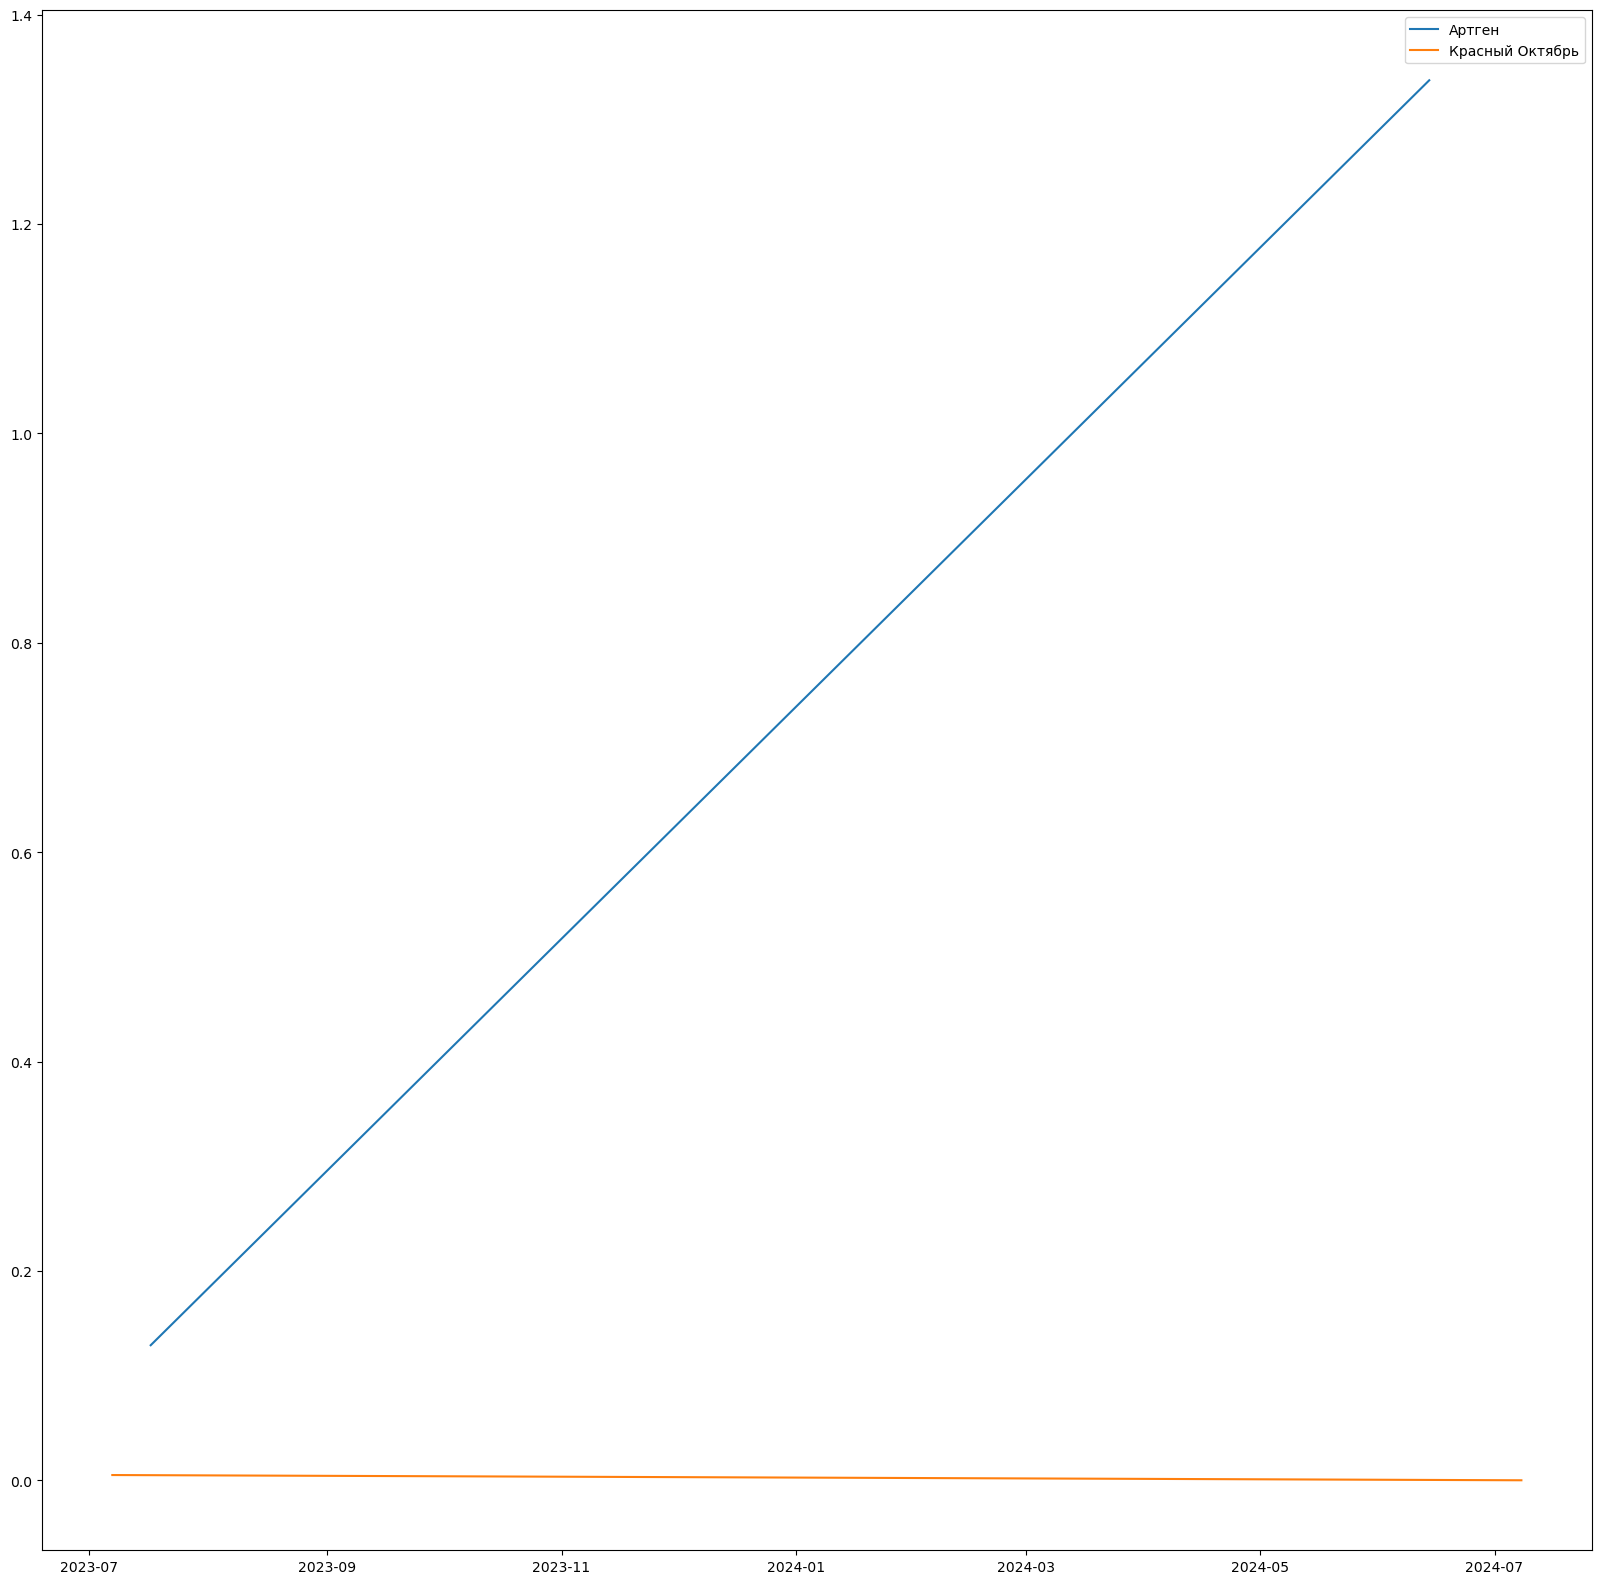

In [122]:
draw_graphs(graphs, 80, 90)